In [134]:
from __future__ import division, absolute_import, print_function
%load_ext autoreload
%autoreload 2

import os 
print(os.getcwd()) 
    
#import hepran
#import hepran.bzipscore as bz
#import hepran.bcipa as bc
#import hepran.utils as u
#import hepran.registers as r
#import hepran.agadir as ag

import pandas as pd
import numpy as np
import seaborn as sns
    
%matplotlib inline

import matplotlib as mpl
import matplotlib.pylab as plt

import sklearn as sk


CCO = os.environ.get("CCO",r"C:\Projekti_KI\ortoCC\CoiledCoilOrtho")

from score_utils import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
d:\data\ortoCC\fine_tune_scoring_function


In [135]:
from interactive_set_plot import *

import bokeh
import bokeh.resources
import bokeh.plotting as bp
from bokeh.models import HoverTool
from IPython.core.display import display, HTML
import hepran
bp.output_notebook()

import sklearn
from sklearn import linear_model
from sklearn.externals import joblib

from IPython.display import display, HTML

Loading BokehJS ...

In [136]:
%%time
df = pd.read_excel('data/round0_fiting.xlsx',index_col=[0,1])
df = df.apply(get_CC_features, axis=1)

Wall time: 1.13 s


In [137]:
fit_metrics_all =  get_metrics_df().set_index('N_iter fit_type fit_class'.split())
model_features_all = get_features_df().set_index("N_iter fit_type".split())

In [138]:
def set_weights(name, df):
    
    df['weights'] = 1
    if name == "W10L15H55":
        df['weights'] = 1
        df.loc[df.Tm < 15, 'weights'] = 10
        df.loc[df.Tm > 55, 'weights'] = 10
        df.loc[df.on_target, 'weights'] = 10
    if name == "W10L15H50":
        df['weights'] = 1
        df.loc[df.Tm < 15, 'weights'] = 10
        df.loc[df.Tm > 50, 'weights'] = 10
        df.loc[df.on_target, 'weights'] = 10
    if name == "W10":
        df.loc[df.on_target, 'weights'] = 10
    if name == "W10L":
        df['weights'] = 1
        df.loc[df.Tm < 15, 'weights'] = 10
        df.loc[df.on_target, 'weights'] = 10

In [139]:
basic = 'c_NN c_IN c_II es_EE es_EK es_KK'.split()
basicL = 'c_NN c_IN c_II es_EE es_EK es_KK cd_LL'.split()
basicCP = 'cp_EEIIEE cp_EEINEE cp_EENNEE cp_EKIIEK cp_EKINEK cp_EKNIEK cp_EKNNEK cp_KKIIKK cp_KKINKK cp_KKNNKK'.split()
nterm_core = 'nterm_c_NN nterm_c_IN nterm_c_II'.split()
cterm_core = 'cterm_c_NN cterm_c_IN cterm_c_II'.split()
core_ends = nterm_core + cterm_core 

core_vertical = 'cv_NN cv_II cv_NI cv_IN'.split()
es_vertical = 'esv_KK esv_EE esv_EK esv_KE'.split()

core_t_vertical = 'cvt_INI cvt_IIN cvt_NII cvt_NNI cvt_NNN cvt_NIN cvt_INN cvt_III'.split()
es_t_vertical = 'esvt_EKK esvt_EEK esvt_EEE esvt_EKE esvt_KEE esvt_KKK esvt_KKE esvt_KEK'.split()
interface_rep = ['interface_repulsion']

fit_fields_dic = {
    "basic": basic,
    "basic-ends": basic + core_ends,
    "basic-rep": basic + interface_rep,
    "basic-core_vertical": basic + core_vertical, 
    "basic-ends_rep": basic + core_ends + interface_rep,
    "basic-rep-core_vertical": basic + interface_rep + core_vertical, 
    "basic-rep-nter_core-vertical_t_all": basic + interface_rep + nterm_core + core_t_vertical + es_t_vertical,
    "basic-rep-core_t_vertical": basic + interface_rep +  core_t_vertical,
    "basic-rep-nter_core-core_vertical": basic + interface_rep + nterm_core + core_vertical,
    "basic-rep-core_vertical": basic + interface_rep + core_vertical,
    "basic-rep-es_t_vertical": basic + interface_rep + es_t_vertical,
    "basic-rep-core_vertical": basic + interface_rep +  core_vertical,
    "basic-rep-nter_core": basic + interface_rep + nterm_core,
    "basicL": basicL,
    "basicL-ends": basicL + core_ends,
    "basicL-rep": basicL + interface_rep,
    "basicL-core_vertical": basicL + core_vertical, 
    "basicL-ends_rep": basicL + core_ends + interface_rep,
    "basicL-rep-core_vertical": basicL + interface_rep + core_vertical, 
    "basicL-rep-nter_core-vertical_t_all": basicL + interface_rep + nterm_core + core_t_vertical + es_t_vertical,
    "basicL-rep-core_t_vertical": basicL + interface_rep +  core_t_vertical,
    "basicL-rep-nter_core-core_vertical": basicL + interface_rep + nterm_core + core_vertical,
    "basicL-rep-core_vertical": basicL + interface_rep + core_vertical,
    "basicL-rep-es_t_vertical": basicL + interface_rep + es_t_vertical,
    "basicL-rep-core_vertical": basicL + interface_rep +  core_vertical,
    "basicL-rep-nter_core": basicL + interface_rep + nterm_core,
    "basicL-nter_core": basicL + nterm_core,    
    "basicCP": basicCP,
    "basicCP-ends": basicCP + core_ends,
    "basicCP-rep": basicCP + interface_rep,
    "basicCP-core_vertical": basicCP + core_vertical, 
    "basicCP-ends_rep": basicCP + core_ends + interface_rep,
    "basicCP-rep-core_vertical": basicCP + interface_rep + core_vertical, 
    "basicCP-rep-nter_core-vertical_t_all": basicCP + interface_rep + nterm_core + core_t_vertical + es_t_vertical,
    "basicCP-rep-core_t_vertical": basicCP + interface_rep +  core_t_vertical,
    "basicCP-rep-nter_core-core_vertical": basicCP + interface_rep + nterm_core + core_vertical,
    "basicCP-rep-core_vertical": basicCP + interface_rep + core_vertical,
    "basicCP-rep-es_t_vertical": basicCP + interface_rep + es_t_vertical,
    "basicCP-rep-core_vertical": basicCP + interface_rep +  core_vertical,
    "basicCP-rep-nter_core": basicCP + interface_rep + nterm_core,
}
extra_cols=[]

In [140]:
fit_type_string = "basicCP-rep-nter_core"
lm_type = "BayesianRidge" #Ridge, ElasticNet, SGDRegressor, BayesianRidge
weight_string="W1" #W1 W10 W10L15H50 W10L15H55

#read ENV vars if they are set
fit_type_string = os.environ.get('fit_type_string', fit_type_string)
lm_type = os.environ.get('lm_type', lm_type)
weight_string = os.environ.get('weight_string', weight_string)

Iteration:  0
Num points:  172


corrR  R2_score  \
N_iter fit_type                               fit_class                       
0      basicCP-rep-nter_core-W1-BayesianRidge all        0.756468  0.570994   
                                              Tm>25      0.689021  0.262761   
                                              Tm>55      0.745880 -4.138697   
                                              on_target  0.475663 -2.717654   

                                                              RMSE  \
N_iter fit_type                               fit_class              
0      basicCP-rep-nter_core-W1-BayesianRidge all        11.540677   
                                              Tm>25      11.502635   
                                              Tm>55      13.785026   
                                              on_target  11.959365   

                                                         med_abs_err  \
N_iter fit_type                               fit_class                
0      basicCP-rep-nter_core-W1-BayesianRidge all           2.703505   
                                              Tm>25         2.715169   
                                              Tm>55         3.397827   
                                              on_target     3.089535   

                                                         explained_var  \
N_iter fit_type                               fit_class                  
0      basicCP-rep-nter_core-W1-BayesianRidge all             0.570994   
                                              Tm>25           0.452756   
                                              Tm>55          -0.136354   
                                              on_target      -0.145190   

                                                         Baysian_IC  \
N_iter fit_type                               fit_class               
0      basicCP-rep-nter_core-W1-BayesianRidge all        918.594427   
                                              Tm>25      532.397612   
                                              Tm>55      113.046181   
                                              on_target   96.829951   

                                                           Akaike_IC  \
N_iter fit_type                               fit_class                
0      basicCP-rep-nter_core-W1-BayesianRidge all        1756.751060   
                                              Tm>25       926.707763   
                                              Tm>55       140.407124   
                                              on_target   119.375231   

                                                        N_samples N_feat  
N_iter fit_type                               fit_class                   
0      basicCP-rep-nter_core-W1-BayesianRidge all             172     15  
                                              Tm>25            95     15  
                                              Tm>55            14     15  
                                              on_target        12     15

feature      coef
N_iter fit_type                                                             
0      basicCP-rep-nter_core-W1-BayesianRidge            cp_EEIIEE -3.942091
       basicCP-rep-nter_core-W1-BayesianRidge            cp_EEINEE -3.729156
       basicCP-rep-nter_core-W1-BayesianRidge            cp_EENNEE -2.731003
       basicCP-rep-nter_core-W1-BayesianRidge            cp_EKIIEK  5.225762
       basicCP-rep-nter_core-W1-BayesianRidge            cp_EKINEK -1.641619
       basicCP-rep-nter_core-W1-BayesianRidge            cp_EKNIEK  0.089920
       basicCP-rep-nter_core-W1-BayesianRidge            cp_EKNNEK  5.891828
       basicCP-rep-nter_core-W1-BayesianRidge            cp_KKIIKK  1.581931
       basicCP-rep-nter_core-W1-BayesianRidge            cp_KKINKK -0.450349
       basicCP-rep-nter_core-W1-BayesianRidge            cp_KKNNKK -0.295224
       basicCP-rep-nter_core-W1-BayesianRidge  interface_repulsion -0.413418
       basicCP-rep-nter_core-W1-BayesianRidge           nterm_c_NN  4.364839
       basicCP-rep-nter_core-W1-BayesianRidge           nterm_c_IN  0.743108
       basicCP-rep-nter_core-W1-BayesianRidge           nterm_c_II -5.107947

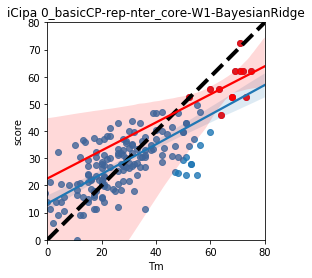

In [142]:

fit_type = fit_type_string
fit_fields = fit_fields_dic[fit_type_string]

set_weights(weight_string, df)
if weight_string:
    fit_type += "-" + weight_string


Q=df
N_iter = 0
print("Iteration: ", N_iter)
print("Num points: ", len(Q))
lm, R2 = make_model('Tm', fit_fields, Q, lm_type)
fit_type += "-" + lm_type 

df['score'] = lm.predict(df[fit_fields])
df['pos'] = 0



df = df.apply(get_formated_seq, axis=1)
df['IDs']=df.index
title = str(N_iter)+"_"+fit_type
#bp.output_file(title=title, filename='models\\{title}.plot.html'.format(**locals()))
p = draw_scatter_interactive('Tm','score',df, y_range=(0,80),                                
                                 title=title, save_to_file=False)


bp.show(p)

mpl_plot_fit(title, df)

fit_metric = get_FIT_dataframe(Q, lm, N_iter, fit_type, N_feat=len(lm.coef_)+1, N_samples=len(Q))
fit_metrics_all = fit_metrics_all.append(fit_metric)
display(fit_metric)
model_features = get_model_features(lm, fit_fields, N_iter, fit_type)
model_features_all = model_features_all.append(model_features)
display(model_features)



joblib.dump(lm, 'models/{title}.model'.format(**locals())); 
df.to_excel('models/{title}.score.xlsx'.format(**locals()));
bp.save(p, title=title, filename='models\\{title}.plot.html'.format(**locals()), resources=bokeh.resources.INLINE);

corrR  R2_score  \
N_iter fit_type                               fit_class                       
1      basicCP-rep-nter_core-W1-BayesianRidge all        0.822943  0.676342   
                                              Tm>25      0.778081  0.477803   
                                              Tm>55      0.774953 -2.700131   
                                              on_target  0.475762 -1.090997   

                                                              RMSE  \
N_iter fit_type                               fit_class              
1      basicCP-rep-nter_core-W1-BayesianRidge all        10.024029   
                                              Tm>25       9.680783   
                                              Tm>55      11.697407   
                                              on_target   8.969131   

                                                         med_abs_err  \
N_iter fit_type                               fit_class                
1      basicCP-rep-nter_core-W1-BayesianRidge all           2.583287   
                                              Tm>25         2.414973   
                                              Tm>55         3.302229   
                                              on_target     2.613091   

                                                         explained_var  \
N_iter fit_type                               fit_class                  
1      basicCP-rep-nter_core-W1-BayesianRidge all             0.676342   
                                              Tm>25           0.593630   
                                              Tm>55          -0.184748   
                                              on_target       0.031450   

                                                         Baysian_IC  \
N_iter fit_type                               fit_class               
1      basicCP-rep-nter_core-W1-BayesianRidge all        870.127287   
                                              Tm>25      499.635275   
                                              Tm>55      108.448141   
                                              on_target   89.924529   

                                                           Akaike_IC  \
N_iter fit_type                               fit_class                
1      basicCP-rep-nter_core-W1-BayesianRidge all        1708.283920   
                                              Tm>25       893.945426   
                                              Tm>55       135.809084   
                                              on_target   112.469809   

                                                        N_samples N_feat  
N_iter fit_type                               fit_class                   
1      basicCP-rep-nter_core-W1-BayesianRidge all             172     15  
                                              Tm>25            95     15  
                                              Tm>55            14     15  
                                              on_target        12     15

feature       coef
N_iter fit_type                                                              
1      basicCP-rep-nter_core-W1-BayesianRidge            cp_EEIIEE   2.864892
       basicCP-rep-nter_core-W1-BayesianRidge            cp_EEINEE  -4.255125
       basicCP-rep-nter_core-W1-BayesianRidge            cp_EENNEE  -0.589662
       basicCP-rep-nter_core-W1-BayesianRidge            cp_EKIIEK  16.735422
       basicCP-rep-nter_core-W1-BayesianRidge            cp_EKINEK   1.495227
       basicCP-rep-nter_core-W1-BayesianRidge            cp_EKNIEK   1.420814
       basicCP-rep-nter_core-W1-BayesianRidge            cp_EKNNEK   5.729836
       basicCP-rep-nter_core-W1-BayesianRidge            cp_KKIIKK  10.385544
       basicCP-rep-nter_core-W1-BayesianRidge            cp_KKINKK   1.053612
       basicCP-rep-nter_core-W1-BayesianRidge            cp_KKNNKK  -1.984368
       basicCP-rep-nter_core-W1-BayesianRidge  interface_repulsion  -0.347101
       basicCP-rep-nter_core-W1-BayesianRidge           nterm_c_NN   3.193215
       basicCP-rep-nter_core-W1-BayesianRidge           nterm_c_IN   1.766513
       basicCP-rep-nter_core-W1-BayesianRidge           nterm_c_II  -4.959728

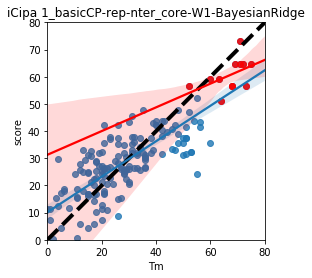

In [144]:
N_iter = 1
seqs = df

%run -i 08_aligned_fit_DO_ITER.py

corrR  R2_score  \
N_iter fit_type                               fit_class                       
2      basicCP-rep-nter_core-W1-BayesianRidge all        0.837571  0.700744   
                                              Tm>25      0.783254  0.483968   
                                              Tm>55      0.766385 -1.506774   
                                              on_target  0.472237 -0.505947   

                                                             RMSE  \
N_iter fit_type                               fit_class             
2      basicCP-rep-nter_core-W1-BayesianRidge all        9.638756   
                                              Tm>25      9.623466   
                                              Tm>55      9.628057   
                                              on_target  7.611644   

                                                         med_abs_err  \
N_iter fit_type                               fit_class                
2      basicCP-rep-nter_core-W1-BayesianRidge all           2.488261   
                                              Tm>25         2.488085   
                                              Tm>55         2.959532   
                                              on_target     2.414834   

                                                         explained_var  \
N_iter fit_type                               fit_class                  
2      basicCP-rep-nter_core-W1-BayesianRidge all             0.700744   
                                              Tm>25           0.584388   
                                              Tm>55           0.020499   
                                              on_target       0.094805   

                                                         Baysian_IC  \
N_iter fit_type                               fit_class               
2      basicCP-rep-nter_core-W1-BayesianRidge all        856.644895   
                                              Tm>25      498.507016   
                                              Tm>55      102.996939   
                                              on_target   85.985899   

                                                           Akaike_IC  \
N_iter fit_type                               fit_class                
2      basicCP-rep-nter_core-W1-BayesianRidge all        1694.801528   
                                              Tm>25       892.817167   
                                              Tm>55       130.357882   
                                              on_target   108.531179   

                                                        N_samples N_feat  
N_iter fit_type                               fit_class                   
2      basicCP-rep-nter_core-W1-BayesianRidge all             172     15  
                                              Tm>25            95     15  
                                              Tm>55            14     15  
                                              on_target        12     15

feature       coef
N_iter fit_type                                                              
2      basicCP-rep-nter_core-W1-BayesianRidge            cp_EEIIEE   6.190728
       basicCP-rep-nter_core-W1-BayesianRidge            cp_EEINEE  -6.778935
       basicCP-rep-nter_core-W1-BayesianRidge            cp_EENNEE  -2.974745
       basicCP-rep-nter_core-W1-BayesianRidge            cp_EKIIEK  18.774437
       basicCP-rep-nter_core-W1-BayesianRidge            cp_EKINEK   1.946282
       basicCP-rep-nter_core-W1-BayesianRidge            cp_EKNIEK   5.351483
       basicCP-rep-nter_core-W1-BayesianRidge            cp_EKNNEK   7.883301
       basicCP-rep-nter_core-W1-BayesianRidge            cp_KKIIKK  12.674217
       basicCP-rep-nter_core-W1-BayesianRidge            cp_KKINKK  -1.121602
       basicCP-rep-nter_core-W1-BayesianRidge            cp_KKNNKK  -0.831761
       basicCP-rep-nter_core-W1-BayesianRidge  interface_repulsion  -0.294848
       basicCP-rep-nter_core-W1-BayesianRidge           nterm_c_NN   3.027317
       basicCP-rep-nter_core-W1-BayesianRidge           nterm_c_IN   2.282521
       basicCP-rep-nter_core-W1-BayesianRidge           nterm_c_II  -5.309838

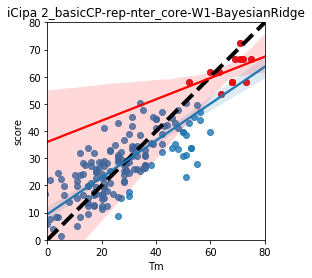

In [146]:
seqs['seq1'] = df['seq1']
seqs['seq2'] = df['seq2']
N_iter += 1

%run -i 08_aligned_fit_DO_ITER.py

corrR  R2_score  \
N_iter fit_type                               fit_class                       
3      basicCP-rep-nter_core-W1-BayesianRidge all        0.831036  0.689779   
                                              Tm>25      0.787230  0.472257   
                                              Tm>55      0.764516 -1.549301   
                                              on_target  0.472729 -0.506784   

                                                             RMSE  \
N_iter fit_type                               fit_class             
3      basicCP-rep-nter_core-W1-BayesianRidge all        9.813744   
                                              Tm>25      9.732051   
                                              Tm>55      9.709382   
                                              on_target  7.613760   

                                                         med_abs_err  \
N_iter fit_type                               fit_class                
3      basicCP-rep-nter_core-W1-BayesianRidge all           2.681322   
                                              Tm>25         2.573504   
                                              Tm>55         3.004018   
                                              on_target     2.414151   

                                                         explained_var  \
N_iter fit_type                               fit_class                  
3      basicCP-rep-nter_core-W1-BayesianRidge all             0.689779   
                                              Tm>25           0.589595   
                                              Tm>55          -0.010487   
                                              on_target       0.090611   

                                                         Baysian_IC  \
N_iter fit_type                               fit_class               
3      basicCP-rep-nter_core-W1-BayesianRidge all        862.834056   
                                              Tm>25      500.638835   
                                              Tm>55      103.232455   
                                              on_target   85.992572   

                                                           Akaike_IC  \
N_iter fit_type                               fit_class                
3      basicCP-rep-nter_core-W1-BayesianRidge all        1700.990689   
                                              Tm>25       894.948986   
                                              Tm>55       130.593398   
                                              on_target   108.537852   

                                                        N_samples N_feat  
N_iter fit_type                               fit_class                   
3      basicCP-rep-nter_core-W1-BayesianRidge all             172     15  
                                              Tm>25            95     15  
                                              Tm>55            14     15  
                                              on_target        12     15

feature       coef
N_iter fit_type                                                              
3      basicCP-rep-nter_core-W1-BayesianRidge            cp_EEIIEE   5.618748
       basicCP-rep-nter_core-W1-BayesianRidge            cp_EEINEE  -5.167349
       basicCP-rep-nter_core-W1-BayesianRidge            cp_EENNEE  -3.302989
       basicCP-rep-nter_core-W1-BayesianRidge            cp_EKIIEK  18.760300
       basicCP-rep-nter_core-W1-BayesianRidge            cp_EKINEK   1.875955
       basicCP-rep-nter_core-W1-BayesianRidge            cp_EKNIEK   3.350811
       basicCP-rep-nter_core-W1-BayesianRidge            cp_EKNNEK   7.203669
       basicCP-rep-nter_core-W1-BayesianRidge            cp_KKIIKK  12.588694
       basicCP-rep-nter_core-W1-BayesianRidge            cp_KKINKK  -1.166666
       basicCP-rep-nter_core-W1-BayesianRidge            cp_KKNNKK  -2.426872
       basicCP-rep-nter_core-W1-BayesianRidge  interface_repulsion  -0.298830
       basicCP-rep-nter_core-W1-BayesianRidge           nterm_c_NN   3.321394
       basicCP-rep-nter_core-W1-BayesianRidge           nterm_c_IN   1.700967
       basicCP-rep-nter_core-W1-BayesianRidge           nterm_c_II  -5.022361

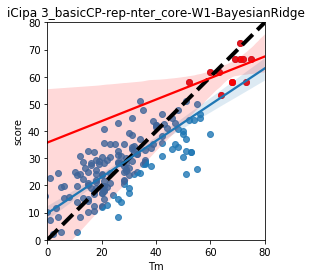

In [148]:
seqs['seq1'] = df['seq1']
seqs['seq2'] = df['seq2']
N_iter += 1

%run -i 08_aligned_fit_DO_ITER.py

corrR  R2_score  \
N_iter fit_type                               fit_class                       
4      basicCP-rep-nter_core-W1-BayesianRidge all        0.835085  0.696540   
                                              Tm>25      0.791773  0.484164   
                                              Tm>55      0.751453 -1.461312   
                                              on_target  0.469730 -0.497829   

                                                             RMSE  \
N_iter fit_type                               fit_class             
4      basicCP-rep-nter_core-W1-BayesianRidge all        9.706218   
                                              Tm>25      9.621636   
                                              Tm>55      9.540352   
                                              on_target  7.591100   

                                                         med_abs_err  \
N_iter fit_type                               fit_class                
4      basicCP-rep-nter_core-W1-BayesianRidge all           2.646201   
                                              Tm>25         2.577959   
                                              Tm>55         2.831345   
                                              on_target     2.311562   

                                                         explained_var  \
N_iter fit_type                               fit_class                  
4      basicCP-rep-nter_core-W1-BayesianRidge all             0.696540   
                                              Tm>25           0.596299   
                                              Tm>55          -0.071959   
                                              on_target       0.035922   

                                                         Baysian_IC  \
N_iter fit_type                               fit_class               
4      basicCP-rep-nter_core-W1-BayesianRidge all        859.044179   
                                              Tm>25      498.470871   
                                              Tm>55      102.740712   
                                              on_target   85.921035   

                                                           Akaike_IC  \
N_iter fit_type                               fit_class                
4      basicCP-rep-nter_core-W1-BayesianRidge all        1697.200812   
                                              Tm>25       892.781023   
                                              Tm>55       130.101655   
                                              on_target   108.466315   

                                                        N_samples N_feat  
N_iter fit_type                               fit_class                   
4      basicCP-rep-nter_core-W1-BayesianRidge all             172     15  
                                              Tm>25            95     15  
                                              Tm>55            14     15  
                                              on_target        12     15

feature       coef
N_iter fit_type                                                              
4      basicCP-rep-nter_core-W1-BayesianRidge            cp_EEIIEE   8.513268
       basicCP-rep-nter_core-W1-BayesianRidge            cp_EEINEE  -4.987882
       basicCP-rep-nter_core-W1-BayesianRidge            cp_EENNEE  -3.491809
       basicCP-rep-nter_core-W1-BayesianRidge            cp_EKIIEK  21.121360
       basicCP-rep-nter_core-W1-BayesianRidge            cp_EKINEK   2.128143
       basicCP-rep-nter_core-W1-BayesianRidge            cp_EKNIEK   4.063668
       basicCP-rep-nter_core-W1-BayesianRidge            cp_EKNNEK   6.834281
       basicCP-rep-nter_core-W1-BayesianRidge            cp_KKIIKK  15.030023
       basicCP-rep-nter_core-W1-BayesianRidge            cp_KKINKK  -0.474791
       basicCP-rep-nter_core-W1-BayesianRidge            cp_KKNNKK  -2.456330
       basicCP-rep-nter_core-W1-BayesianRidge  interface_repulsion  -0.312203
       basicCP-rep-nter_core-W1-BayesianRidge           nterm_c_NN   3.425406
       basicCP-rep-nter_core-W1-BayesianRidge           nterm_c_IN   2.462550
       basicCP-rep-nter_core-W1-BayesianRidge           nterm_c_II  -5.887956

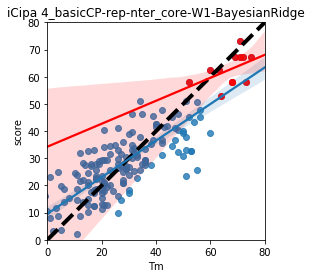

In [150]:
seqs['seq1'] = df['seq1']
seqs['seq2'] = df['seq2']
N_iter += 1

%run -i 08_aligned_fit_DO_ITER.py

corrR  R2_score  \
N_iter fit_type                               fit_class                       
5      basicCP-rep-nter_core-W1-BayesianRidge all        0.835236  0.696805   
                                              Tm>25      0.792927  0.485618   
                                              Tm>55      0.756308 -1.444531   
                                              on_target  0.470015 -0.445391   

                                                             RMSE  \
N_iter fit_type                               fit_class             
5      basicCP-rep-nter_core-W1-BayesianRidge all        9.701975   
                                              Tm>25      9.608070   
                                              Tm>55      9.507773   
                                              on_target  7.457037   

                                                         med_abs_err  \
N_iter fit_type                               fit_class                
5      basicCP-rep-nter_core-W1-BayesianRidge all           2.639017   
                                              Tm>25         2.556658   
                                              Tm>55         2.926176   
                                              on_target     2.366565   

                                                         explained_var  \
N_iter fit_type                               fit_class                  
5      basicCP-rep-nter_core-W1-BayesianRidge all             0.696805   
                                              Tm>25           0.598600   
                                              Tm>55          -0.045549   
                                              on_target       0.074713   

                                                         Baysian_IC  \
N_iter fit_type                               fit_class               
5      basicCP-rep-nter_core-W1-BayesianRidge all        858.893760   
                                              Tm>25      498.202791   
                                              Tm>55      102.644932   
                                              on_target   85.493396   

                                                           Akaike_IC  \
N_iter fit_type                               fit_class                
5      basicCP-rep-nter_core-W1-BayesianRidge all        1697.050393   
                                              Tm>25       892.512943   
                                              Tm>55       130.005875   
                                              on_target   108.038676   

                                                        N_samples N_feat  
N_iter fit_type                               fit_class                   
5      basicCP-rep-nter_core-W1-BayesianRidge all             172     15  
                                              Tm>25            95     15  
                                              Tm>55            14     15  
                                              on_target        12     15

feature       coef
N_iter fit_type                                                              
5      basicCP-rep-nter_core-W1-BayesianRidge            cp_EEIIEE   7.431289
       basicCP-rep-nter_core-W1-BayesianRidge            cp_EEINEE  -4.058341
       basicCP-rep-nter_core-W1-BayesianRidge            cp_EENNEE  -3.909709
       basicCP-rep-nter_core-W1-BayesianRidge            cp_EKIIEK  20.724990
       basicCP-rep-nter_core-W1-BayesianRidge            cp_EKINEK   2.535264
       basicCP-rep-nter_core-W1-BayesianRidge            cp_EKNIEK   4.143990
       basicCP-rep-nter_core-W1-BayesianRidge            cp_EKNNEK   6.653843
       basicCP-rep-nter_core-W1-BayesianRidge            cp_KKIIKK  14.651520
       basicCP-rep-nter_core-W1-BayesianRidge            cp_KKINKK  -0.977757
       basicCP-rep-nter_core-W1-BayesianRidge            cp_KKNNKK  -3.093288
       basicCP-rep-nter_core-W1-BayesianRidge  interface_repulsion  -0.296554
       basicCP-rep-nter_core-W1-BayesianRidge           nterm_c_NN   3.681184
       basicCP-rep-nter_core-W1-BayesianRidge           nterm_c_IN   1.436371
       basicCP-rep-nter_core-W1-BayesianRidge           nterm_c_II  -5.117555

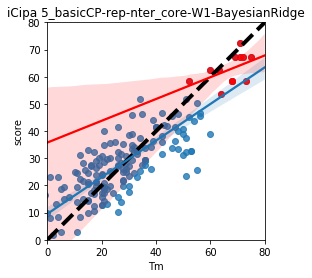

In [152]:
seqs['seq1'] = df['seq1']
seqs['seq2'] = df['seq2']
N_iter += 1

%run -i 08_aligned_fit_DO_ITER.py

In [154]:
fit_metrics_all.to_csv('models/{fit_type}.metrics.csv'.format(**locals()) ) 
model_features_all.to_csv('models/{fit_type}.metrics.csv'.format(**locals()) ) 